In [13]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import shutil
import random

In [ ]:

# Enable mixed precision training
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# Set dataset paths
source_dir = "Global"  # Update this to the actual dataset path
target_dir = "Batch"

# Ensure target directory exists
os.makedirs(target_dir, exist_ok=True)

# Limit dataset to 1000 images per class
num_images_per_class = 1000

for class_name in os.listdir(source_dir):
    class_path = os.path.join(source_dir, class_name)
    if os.path.isdir(class_path):
        # Create target class directory
        target_class_path = os.path.join(target_dir, class_name)
        os.makedirs(target_class_path, exist_ok=True)
        
        # Select 1000 random images
        images = os.listdir(class_path)
        selected_images = random.sample(images, min(num_images_per_class, len(images)))
        
        # Copy selected images to new dataset
        for img in selected_images:
            shutil.copy(os.path.join(class_path, img), os.path.join(target_class_path, img))

# Update data directory to use the filtered dataset
data_dir = target_dir

# Image size and batch size
img_size = (96, 96)
batch_size = 128

# Data Augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,  # 80-20 train-validation split
    rotation_range=10,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True
)

# Load Data
train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 1600 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [15]:
# Load Pretrained Model (EfficientNetB0 without top layers)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
for layer in base_model.layers[:-5]:  # Freeze most layers for faster training
    layer.trainable = False  

# Custom CNN Head
x = Flatten()(base_model.output)
x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(1, activation='sigmoid', dtype='float32')(x)  # Ensure float32 output for precision

model = Model(inputs=base_model.input, outputs=out)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9), loss='binary_crossentropy', metrics=['accuracy'])

# Train Model with Early Stopping and Learning Rate Adjustment
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
history = model.fit(train_generator, validation_data=val_generator, epochs=10, callbacks=[early_stop, lr_reduce])

# Extract Features for ML Classifiers
feature_extractor = Model(inputs=model.input, outputs=model.layers[-2].output)
X, y = [], []

for batch_x, batch_y in train_generator:
    features = feature_extractor.predict(batch_x, batch_size=batch_size)
    X.extend(features)
    y.extend(batch_y)
    if len(X) >= train_generator.samples:
        break

X = np.array(X)
y = np.array(y)

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


16705208/16705208 [==============================] - 20s 1us/step
Epoch 1/10
13/13 [==============================] - 275s 21s/step - loss: 5.9526 - accuracy: 0.4825 - val_loss: 6.6795 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 2/10
13/13 [==============================] - 266s 21s/step - loss: 5.6524 - accuracy: 0.4837 - val_loss: 5.6922 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 3/10
13/13 [==============================] - 294s 23s/step - loss: 5.4421 - accuracy: 0.4775 - val_loss: 5.2867 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 4/10
13/13 [==============================] - 311s 24s/step - loss: 5.2004 - accuracy: 0.4869 - val_loss: 5.0759 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 5/10
13/13 [==============================] - 310s 24s/step - loss: 4.9643 - accuracy: 0.4850 - val_loss: 4.8175 - val_accuracy: 0.5000 - lr: 0.0100
Epoch 6/10
13/13 [==============================] - 317s 24s/step - loss: 4.7205 - accuracy: 0.5169 - val_loss: 4.6053 - val_accuracy: 0.5000 - lr: 0.0100
Epoc

In [16]:
# Define Classifiers
classifiers = {
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(n_estimators=100),
    'SVM': SVC(kernel='linear', probability=True),
    'Naive Bayes': GaussianNB()
}

# Train and Evaluate Each Classifier
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    results[name] = {
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1 Score': f1_score(y_test, y_pred)
    }
    print(f"\n{name} Classifier Results:")
    print(classification_report(y_test, y_pred))

# Print Summary of Classifier Performance
for name, metrics in results.items():
    print(f"\n{name} Performance:")
    for metric, value in metrics.items():
        print(f"{metric}: {value:.4f}")


KNN Classifier Results:
              precision    recall  f1-score   support

         0.0       0.66      0.66      0.66       170
         1.0       0.62      0.62      0.62       150

    accuracy                           0.64       320
   macro avg       0.64      0.64      0.64       320
weighted avg       0.64      0.64      0.64       320


Decision Tree Classifier Results:
              precision    recall  f1-score   support

         0.0       0.60      0.58      0.59       170
         1.0       0.54      0.56      0.55       150

    accuracy                           0.57       320
   macro avg       0.57      0.57      0.57       320
weighted avg       0.57      0.57      0.57       320


Random Forest Classifier Results:
              precision    recall  f1-score   support

         0.0       0.66      0.71      0.68       170
         1.0       0.64      0.58      0.61       150

    accuracy                           0.65       320
   macro avg       0.65      0.65

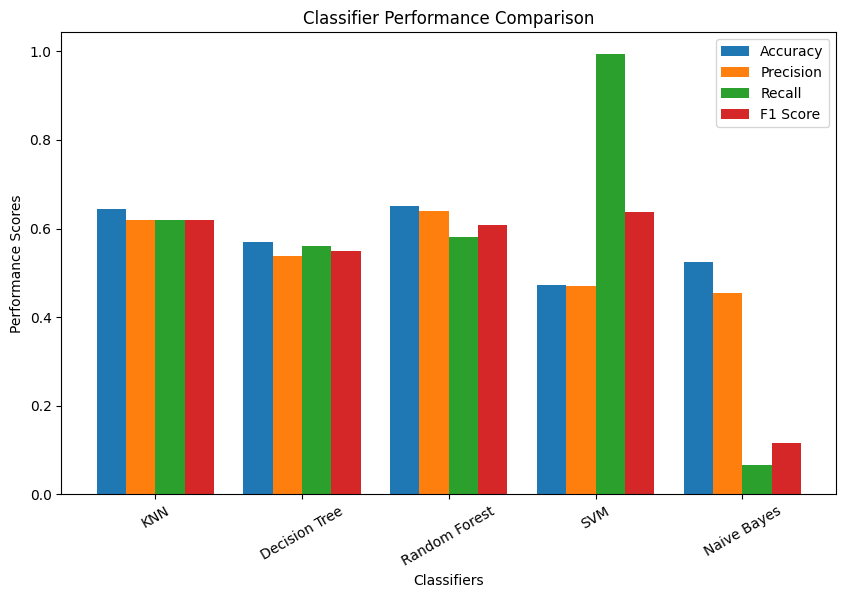

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Extract metrics
metrics = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
classifiers = list(results.keys())

# Convert dictionary results to a numpy array
values = np.array([[results[clf][metric] for metric in metrics] for clf in classifiers])

# Plot
x = np.arange(len(classifiers))  # Label locations
width = 0.2  # Bar width

fig, ax = plt.subplots(figsize=(10, 6))

# Create bars for each metric
for i, metric in enumerate(metrics):
    ax.bar(x + i * width, values[:, i], width, label=metric)

# Labels and formatting
ax.set_xlabel("Classifiers")
ax.set_ylabel("Performance Scores")
ax.set_title("Classifier Performance Comparison")
ax.set_xticks(x + width * (len(metrics) / 2 - 0.5))
ax.set_xticklabels(classifiers, rotation=30)
ax.legend()

# Show plot
plt.show()
